# Bayesian Estimation of Mixed Logit Models

This workbook shares key details of the estimation routine I used in the **[bayesmixedlogit](https://ideas.repec.org/c/boc/bocode/s457620.html)** package in Stata. The hope is that by making coding and other basic details accessible, modification for specific purposes will be made easier for other researchers. And now that I have some experience with a variety of use cases, it might be worthwhile to rethink the code more generally. 

I have received questions about how one might make code more efficient for larger problems, or how one might implement an identity covariance matrix, or how one might include prior information about coefficients,to give a few examples. Hopefully, with the help of the code here, researchers will have a better idea as to how to proceed in developing these extensions. 
 

# Theoretical overview

The basic approach is well-described in [Train (2009)](http://eml.berkeley.edu/books/choice2.html), and the implementation here closely follows that descrbed in [Baker (2015)](http://www.stata-journal.com/article.html?article=st0354).

Suppose that the utility that individual $n$ obtains from making choice $j$ at time $t$ can be written as:

$$
U_{njt} = \beta_n x_{njt} + \epsilon_{njt}
$$

where $\epsilon_{njt}$ is an i.i.d. extreme value error term, and $\beta_n$ are individual-specific parameters. Across individuals, these individual-specific parameters are normally distributed with mean $b$ and covariance matrix $W$. 

Let $y_{nt}$ denotes the choices of individual $n$ at $t$. Given distributional assumptions, the probability $n$ makes choice sequence $y$ at different times $t$: 

$$
L(y_n|\beta) = \Pi_t \frac{e^{\beta_nx_{n_{y_{nt}}t}}}{\sum_{j=1}^Je^{\beta_nx_{njt}}}
$$

So, now have the likelihood of choices, given the parameter distribution, and prior distribution of parameters, as:

$$
L = \Pi_n L(y_n|\beta_n)\phi(\beta_n|b,W)h(b,W)
$$

# Bayesian Estimation via a Gibbs sampler

The likelihood admits a rather natural choice for Gibbs sampling, as [Train (2009)](http://eml.berkelely.edu/books/choice2.html) describes. The essential idea is familiar in Bayesian analysis: treat things that are unobserved (i.e., individual-level parameters) as additional parameters to be drawn/estimated. Anyways, the Gibbs steps are:

1. Draw $b$, given $\beta_n,W$. 
2. Draw $W$, given $\beta_n,b$.
3. Draw $\beta_n$, given $b,W$. 

Each step requires a (conditional) distribution. These are as follows:

1. $b \sim N(\overline{\beta}, WN^{-1})$.
2. $W$ is inverted Wishart with $K+N$ degrees of freedom and scale matrix $(KI+NS)/(K+N)$, where $S=N^{-1}\sum_n(\beta_n-b)(\beta_n-b)'$
3. $\beta_n$ given choices, data, and $(b,W)$ has no simple form, but can be drawn using a MCMC step, following the basic relationship: $K(\beta_n|b,W) \propto L(y_n|\beta_n)\phi(\beta_n|b,W)$. This is the hard part - as it happens, every time I have devised a Gibbs sampler, there is a hard part!


# Stata Code

Here, we will use the excellent module **[ipystata](https://github.com/TiesdeKok/ipystata)** to weave the code into our workbook. If you haven't worked in this framework before, you should. The first thing to do is to download and install a distribution of Python - preferably one that comes prepackaged with Jupyter, like **[Anaconda](https://www.continuum.io/downloads)**. Then, one can go ahead and install **[ipystata](https://github.com/TiesdeKok/ipystata)** following the instructions at the linked page. Anyways:

In [10]:
import ipystata

from IPython.display import IFrame

Now, we can get a dataset going - we will follow the basic example in Train (2009), but also found in [Baker (2015)](https://www.researchgate.net/publication/263888759_Adaptive_Markov_chain_Monte_Carlo_sampling_and_estimation_in_Mata). 

In [3]:
%%stata

clear all
set more off 
use http://fmwww.bc.edu/repec/bocode/t/traindata.dta
set seed 90210

PID could not be obtained, can only be closed by using "close all".




As a starter, we will just fit a **`mixlogit`** model using [Arne Hole's package](http://www.stata.com/meeting/uk13/abstracts/materials/uk13_hole.pdf) (after first installing it if it is not already there).

In [4]:
%%stata

capture ssc install mixlogit

In [5]:
%%stata

mixlogit y, rand(price contract local wknown tod seasonal) group(gid) id(pid)


Iteration 0:   log likelihood = -1253.1345  (not concave)
Iteration 1:   log likelihood = -1163.1407  (not concave)
Iteration 2:   log likelihood = -1142.7635  
Iteration 3:   log likelihood = -1123.6896  
Iteration 4:   log likelihood = -1122.6326  
Iteration 5:   log likelihood = -1122.6226  
Iteration 6:   log likelihood = -1122.6226  

Mixed logit model                               Number of obs     =      4,780
                                                LR chi2(6)        =     467.53
Log likelihood = -1122.6226                     Prob > chi2       =     0.0000

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
Mean         |
       price |  -.8908633   .0616638   -14.45   0.000    -1.011722   -.7700045
    contract |    -.22285   .0390333    -5.71   0.000    -.2993539   -.1463462
       lo

So, we now have a benchmark as to what we are after. Let's now create a few `mata` functions that will allow us to execute the steps in the Gibbs sampler. First, we would like a means of drawing $b$. Here is one such function:

In [6]:
%%stata --mata

real matrix drawb_betaW(beta, W) {
    return( mean(beta) + rnormal(1, cols(beta) ,0 ,1 ) * cholesky(W)' )
}

Mata output:




Following Train's (2009) description, we have the means of drawing $W$ given $\beta$ and $b$:

In [7]:
%%stata --mata

real matrix drawW_bbeta(beta, b) {
    v  = rnormal( cols(b) + rows(beta), cols(b), 0, 1)
    S1 = variance(beta :- b)
    S  = invsym((cols(b)*I(cols(b)) + rows(beta) * S1)/(cols(b) + rows(beta)))
    L  = cholesky(S)
    R = (L*v')*(L*v')' / (cols(b) + rows(beta))
    return(invsym(R))
}

Mata output:




So, the above basically give us two of the three Gibbs steps that we need. The last thing that is needed is a means of drawing the individual-level parameters for each individual. This is the tricky part and generically requires an MCMC step for each individual. 

**Point of interest: If you are someone who is running a "big" model, it strikes me that this is the place where there are the biggest possibilities for improving the routine. Here is the log-likelihood of observing an individuals choices, given their individual level parameters. **


In [8]:
%%stata --mata

real scalar lncp(real rowvector beta_rn,
                 real rowvector b,
                 real matrix Winv,
                 real matrix ldetW,
                 real matrix y,
                 real matrix Xr,
                 real matrix cid)
{
    
    real scalar i, lnp, lnprior
    real matrix z, Xrp, yp, mus
 
    z   = panelsetup(cid, 1)
    
    lnp = 0
    
    for (i=1; i<=rows(z); i++) {
        Xrp  = panelsubmatrix(Xr, i, z)
         yp  = panelsubmatrix(y,  i, z)
         mus = rowsum(Xrp:*beta_rn)
         max = max(mus)
         sum = max + ln(colsum(exp(mus :- max)))
         lnp = lnp + colsum(yp:*mus) :- sum
    }

    lnprior= -1/2*(beta_rn - b)*Winv*(beta_rn - b)' - 1/2*ldetW - cols(b)/2*ln(2*pi())

    return(lnp + lnprior)
}

Mata output:





As it is seemingly a little more complicated than the other functions, a description might help. First, we see that it takes in values of the random coefficients, `beta_rn`, for the individual. It also requires the value for $b$, the inverse of the variance matrix for the parameters, `Winv`, the log-determinant of this matrix, the choice values (for the individual) `y`, the explanatory variables with random coefficients `Xr`, and the `cid` variables, which identify choice occasions. 

How the function works: in line 15, each choice occasion is run through `panelsetup`, which returns a matrix of indices that indicate where choice occasions begin and end. In line 17, the log-likelihood value is set to zero. In line 19, we iterate through the choice occasions (each row of `z` marks the first and last rows of data pertaining to an occasion). `Xrp` pulls the data for the occasion, while $yp$ pulls the choices. In row 22, we sum up the product of explanatory variables and coefficients which forms the linear choice index. 

In line 23, 24, and 25, we use a numerically stable method of calculating $\frac{e^{\mu_i}}{\sum e^{\mu_j}}$, which in logs can be written as:

$$
\mu_i - \ln (\sum e^{\mu_j})
$$

The problem arises because the sum-log sequence can often generate zeros and missing values. So, the numerical trick to rectify this is to find the largest value in the sum, and factor it out:

$$
\mu_i - \ln (e^M\sum e^{\mu_j-M})
$$

Which then becomes:

$$
\mu_i - M - \ln (\sum e^{\mu_j-M})
$$

This is stable beacuse there is at least one value of one in the sum now, so in the worst-case-scenario, the log-sum term becomes zero, not "missing".

So, in line 25, we get the log-choice probability, which is then added to the running sum `lncp`. Finally, we tack on the prior distribution of the parameters, which is dictated by the value of $b, W$. 


## Sidebar - Adaptive Markov-chain Monte Carlo routines

At this point, we have to talk about how to get draws of individual-level parameters from the above. In my Stata journal paper, I used a general-purpose package that I wrote. Here, however, it is better to lay out the nitty-gritty details as to how this is actually accomplished. 

We will be using a global scheme which draws all parameters for an individual at once. We will need to address the following concerns when developing the routines:

1. Where do we get a new guess at the parameter values?
2. How do we determine if the guess should be accepted or not? 

Adaptive MCMC works by using a proposal distribution which tunes itself as things go along to balance the twin objectives of getting sufficient variation in the draws while also exploring the distribution of the draws fully. The idea is to expand the variance matrix according to some criterion when a draws are too readily accepted, and contract it when they aren't accepted frequently enough. See [Baker (2015)](http://www.stata-journal.com/article.html?article=st0354) for all the gory details. 

The algorithm we are going to use to do the drawing is a global adaptive MCMC algorithm. The idea is to tune the proposal distribution so that we get the right amount of accepted proposals for each individual. Some of the parameters of interest in the algorithm below:

1. $\alpha$ - desired acceptance rate - typically something like .25 in multivariate problems. 
2. $\lambda$ - scale parameter for the proposal variance matrix. This goes up so that the explored parameter range is greater, and contracts so that the acceptance rate is greater.
3. $\Sigma$ - covariance matrix of the proposals.
4. $\mu$ - mean used in calculating $\Sigma$.
5. $\delta$ - damping parameter. This parameter ensures that the proposal distribution is eventually stable in that adjustments to the proposal distribution cease in the limit. Otherwise, we do not have a theoretically sound MCMC algorithm!

## The Exact algorithm

In [14]:
IFrame('AlgPic.pdf', width=800, height=300)

Read in the data:

In [15]:
%%stata --mata

st_view(y=., .,   "y")
st_view(X=., .,   "price contract local wknown tod seasonal")
st_view(pid=., ., "pid")                                            // Individual identifier
st_view(gid=., ., "gid")                                            // choice occasions

Mata output:




### Some initial values for the parameters

In [16]:
%%stata --mata
m = panelsetup(pid, 1)

b = J(1, 6, 0)
W = I(6)*6
beta = b :+ sqrt(diagonal(W))':*rnormal(rows(m), cols(b), 0, 1)

Mata output:




## Basic information describing the run:

20000 total draws, of which we throw out the first 10000 as a burn-in. We store values for mean value of the parameters in  `bvals`, and values for the variance matrix in `W`, as we want to learn about the distribution of these things. 

`atarg` is a factor which we use to target the optimal acceptance rate for the MCMC drawing. See [Baker (2015)](http://www.stata-journal.com/article.html?article=st0354) for the details as to how this value is chosen, and why .25 was selected. 

In [21]:
%%stata --mata

its    = 20000
burn   = 10000
nb     = cols(beta)
bvals  = J(0, cols(beta), .)                    // Store draws of the mean parameter 
Wvals  = J(0, cols(rowshape(W, 1)), .)          // Store draws of the variance parameters

propVs = J(rows(m), 1, rowshape(W, 1))             
propms = J(rows(m), 1, b)                          // Store the proposal mean and variance data for each individual
accept = J(rows(m), 1, 0)                          // Store a count of acceptances so we can monitor acceptance rates

atarg  = .25                                       // target acceptance rate
lam    = J(rows(m), 1, 2.38^2/nb)                  // initial value of the scaling parameter
damper = 1                                         // damping parameter value

Mata output:




## Drawing values

The following loop draws values and stores them in a stacked matrices. Note the inner loop draws individual-level parameters with one MCMC algorithm in action for each individual, and implements the algorithm described above with a few extra bells and whistles that just avoid missing values.  

At the end of the loop, we calculate the acceptance rate for each individual. We would like this to hover in the goldilocks zone for all individuals (.15 to .5, say).

In [22]:
%%stata --mata

for (i=1; i<=its; i++) {
    
    b = drawb_betaW(beta, W/rows(m))
    W = drawW_bbeta(beta, b)
    
    bvals = bvals \ b
    Wvals = Wvals \ rowshape(W, 1)
    
    beta_old = beta
    
    Winv  = invsym(W)
    ldetW = ln(det(W))
    
    for (j=1; j<=rows(m); j++) {
        
        yi   = panelsubmatrix(y, j,m)
        Xi   = panelsubmatrix(X, j, m)
        gidi = panelsubmatrix(gid, j, m)
        
        propV = rowshape(propVs[j, ], nb)
    
        beta_old = beta[j, ]
        beta_hat = beta[j, ] + lam[j]*rnormal(1,nb,0,1)*cholesky(propV)' 

        old = lncp(beta_old, b, Winv, ldetW, yi, Xi, gidi)
        pro = lncp(beta_hat, b, Winv, ldetW, yi, Xi, gidi)
        
        if  (pro == . )     alpha = 0
        else if (pro > old) alpha = 1
        else                alpha = exp(pro - old)
        
        if (runiform(1, 1) < alpha) {
            beta[j, ] = beta_hat
            accept[j] = accept[j] + 1
        }

        lam[j] = lam[j]*exp(1/(i+1)^damper*(alpha - atarg))
        propms[j, ] = propms[j, ] + 1/(i + 1)^damper*(beta[j, ] - propms[j, ])
        propV       = propV + 1/(i + 1)^damper*((beta[j, ] - propms[j, ])'(beta[j, ] - propms[j, ]) - propV)
        _makesymmetric(propV)
        propVs[j, ] = rowshape(propV, 1)    
    }    
}

arates = accept/its       

Mata output:

command end is unrecognized
r(199);



# Analysis of the run

We would like to be sure that the distribution of the parameters makes sense, and that it converges. It is useful to just treat the parameters as a data set and compute means first, but it also helps to treat the data like a time series so we can plot the draws as they occurred.

In [23]:
%%stata 
preserve
clear 
getmata (b*) = bvals

sum b*


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
          b1 |     20,000   -1.091904    .2545802  -1.701797   .5982369
          b2 |     20,000   -.3317827    .0738427  -.6221769   .2870459
          b3 |     20,000    2.529804    .4501374  -.0866471   4.078244
          b4 |     20,000    2.033036    .3826559  -.3001624   3.279535
          b5 |     20,000   -10.47962    2.181933  -15.70531   .1806856
-------------+---------------------------------------------------------
          b6 |     20,000   -10.48301    2.165496  -16.23153   .1156336



The estimated values are more or less in line with those estimated by `mixlogit`. Let's plot draws and see if they seem to have converged to a stable distribution:


        time variable:  t, 1 to 20000
                delta:  1 unit



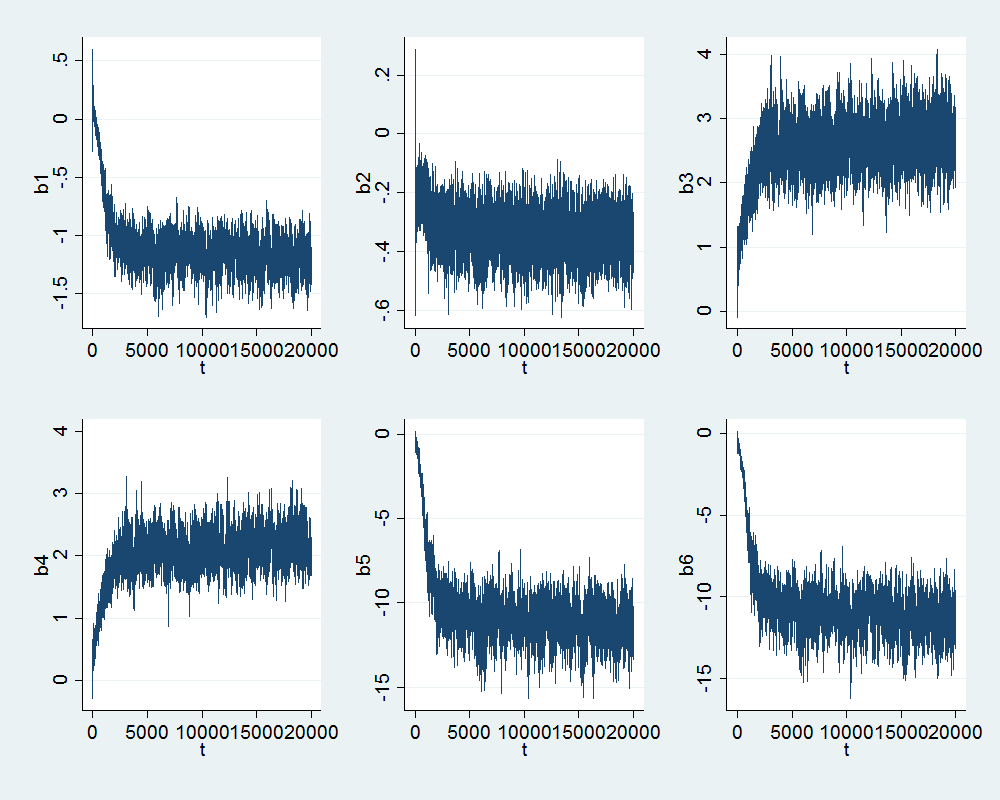

In [24]:
%%stata --graph
gen t = _n
tsset t
forvalues i=1/6 {
    quietly tsline b`i', saving(bg`i'.gph, replace)
	local glist `glist' "bg`i'.gph"
}
graph combine `glist'

## Acceptance rates and damping parameters:


(bin=10, start=.24545, width=.00997)



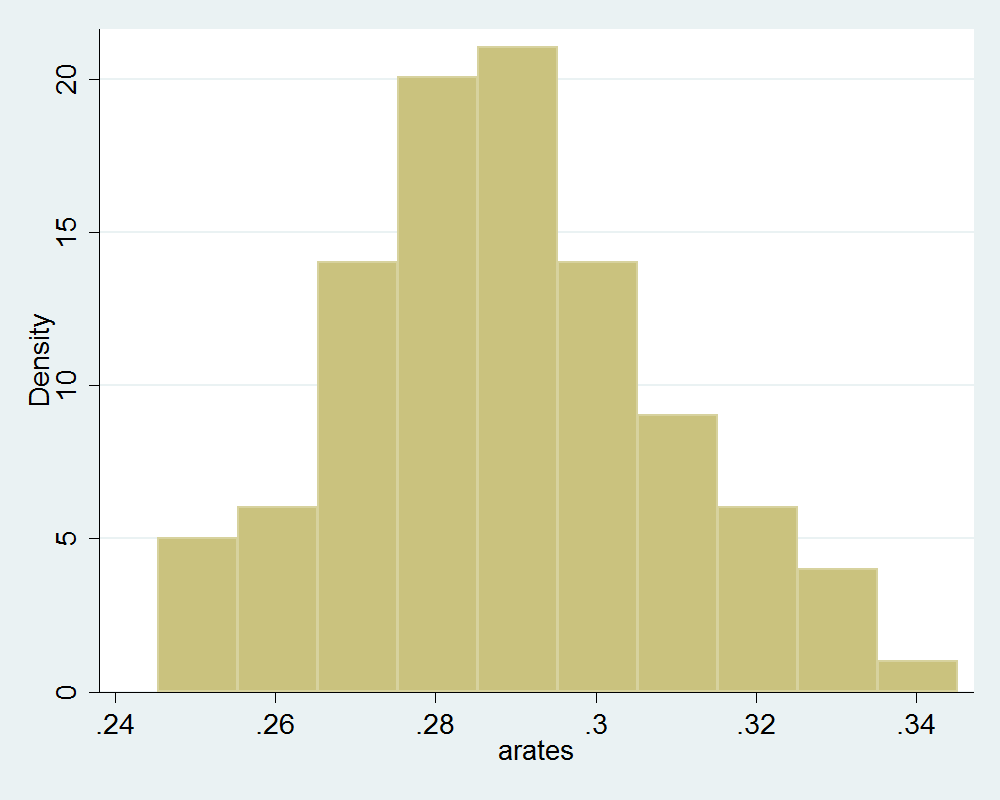

In [26]:
%%stata --graph
clear 
getmata arates lam
hist arates

(bin=10, start=.62125731, width=.03772478)



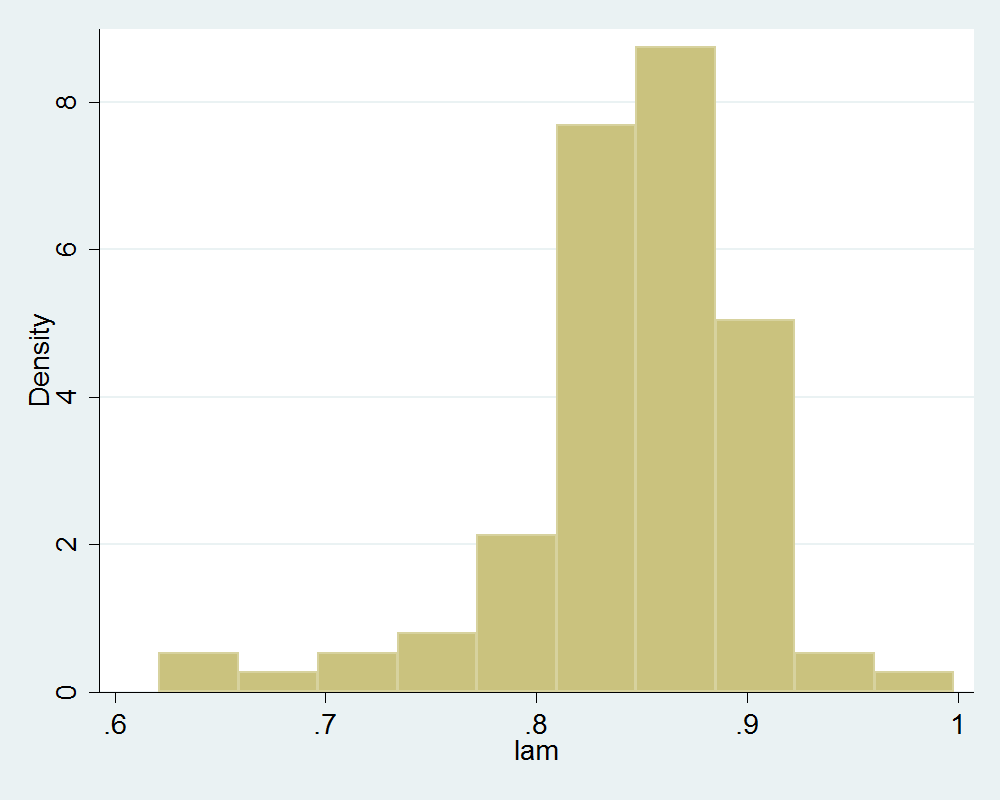

In [27]:
%%stata --graph 
hist lam

The run seems fairly stable in that there doesn't seem to be anything crazy about the individual MCMC runs. The acceptance rates are reasonable, as are muting parameters. The draws also seem to be reasonably converged. 

## Conclusions and suggestions

If you have a comment, why not start up a github account and raise an issue? 